In [38]:
import pandas as pd
import requests
import numpy as np
from IPython.display import Image, HTML
from urllib.request import urlretrieve
import urllib.request
import requests
import shutil
from os import listdir
from PIL import Image as PImage
from collections import Counter
import os, sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, GlobalAveragePooling2D,ZeroPadding2D
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16, mobilenet_v2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [39]:
mushrooms_links = pd.read_csv('mushrooms_img.csv')
mushrooms_links.head()

,Unnamed: 0,Image,edibility
0,0,/images/poisonous32.png,posionous
1,1,/../data/fungi/Amanitabisporigera1-thumb.jpg,posionous
2,2,/../data/fungi/Amanitabisporigera2-thumb.jpg,posionous
3,3,/../data/fungi/Amanitabisporigera3-thumb.jpg,posionous
4,4,/images/poisonous32.png,posionous


In [40]:
mushrooms_links['Link_Half'] = 'https://www.mushroom.world'

#remove all icon image links
mushrooms_links = mushrooms_links[mushrooms_links.Image != '/images/edible32.png']
mushrooms_links = mushrooms_links[mushrooms_links.Image != '/images/inedible32.png']
mushrooms_links = mushrooms_links[mushrooms_links.Image != '/images/poisonous32.png']

#remove unnecessary starting characters
mushrooms_links['Image'] = mushrooms_links['Image'].str[3:]

#dropping column that we dont need
mushrooms_links.drop(columns=['Unnamed: 0'], inplace = True)

#making sure everything workedmushrooms_links
mushrooms_links.head()

,Image,edibility,Link_Half
1,/data/fungi/Amanitabisporigera1-thumb.jpg,posionous,https://www.mushroom.world
2,/data/fungi/Amanitabisporigera2-thumb.jpg,posionous,https://www.mushroom.world
3,/data/fungi/Amanitabisporigera3-thumb.jpg,posionous,https://www.mushroom.world
5,/data/fungi/Amanitaphalloides1-thumb.JPG,posionous,https://www.mushroom.world
6,/data/fungi/Amanitaphalloides2-thumb.jpg,posionous,https://www.mushroom.world


## The cell below downloads all images to your computer!!!

In [ ]:
for img in mushrooms_links["Image"]:
    url = str("https://www.mushroom.world"+img)
    filename = url.split("/")[-1]
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(r.content)

In [41]:
train_ds = image_dataset_from_directory(
  './Mushroom_Images/',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    validation_split=0.15,
    subset="training",
    batch_size=32,
    seed=123)

val_ds = image_dataset_from_directory(
  './Mushroom_Images/',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    validation_split=0.15,
    subset="validation",
    batch_size=32,
    seed=123)

test_ds = image_dataset_from_directory(
   './Test_Images/',
     labels='inferred',
     label_mode='categorical',
     image_size=(256, 256),
     batch_size=32,
     seed=123)

Found 668 files belonging to 2 classes.
Using 568 files for training.
Found 668 files belonging to 2 classes.
Using 100 files for validation.
Found 178 files belonging to 2 classes.


In [42]:
class_names = train_ds.class_names
print(class_names)

['Edible', 'Poisonous']


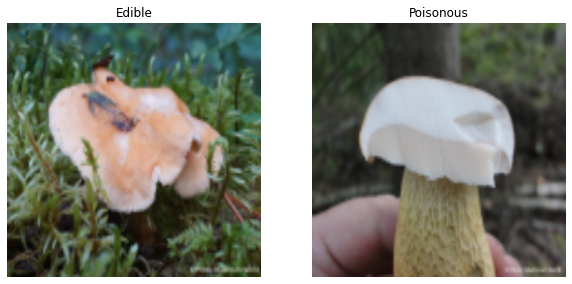

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
        plt.savefig("Images.png", transparent=True)

In [44]:
encoder = LabelEncoder()
encoder.fit(class_names)
encoded_Y = encoder.transform(class_names)

In [45]:
classes = np.array(class_names)

label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(classes)
y_categorical = to_categorical(vec)
y_categorical

array([[1., 0.],
       [0., 1.]], dtype=float32)

In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Baseline NN

In [72]:
Baseline_NN = Sequential()

Baseline_NN.add(InputLayer(input_shape = (256,256,3)))

Baseline_NN.add(Flatten())

Baseline_NN.add(Flatten())

Baseline_NN.add(Dense(2, activation = 'sigmoid'))

Baseline_NN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy','Precision','Recall'])

Baseline_NN.summary()

baseline_history = Baseline_NN.fit(train_ds, epochs = 30, validation_data=val_ds)

Baseline_NN.evaluate(val_ds)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 196608)            0         
                                                                 
 flatten_18 (Flatten)        (None, 196608)            0         
                                                                 
 dense_39 (Dense)            (None, 2)                 393218    
                                                                 
Total params: 393,218
Trainable params: 393,218
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
18/18 [==============================] - 1s 28ms/step - loss: 3494.6841 - accuracy: 0.5246 - precision: 0.5383 - recall: 0.5317 - val_loss: 2345.3176 - val_accuracy: 0.3800 - val_precision: 0.3861 - val_recall: 0.3900
Epoch 2/30
18/18 [==============================] - 0s 14ms/step - loss: 925.2507 

[433.60186767578125,
 0.6200000047683716,
 0.6477272510528564,
 0.5699999928474426]

# Adding More Layers

In [69]:
Sequential_NN = Sequential()

Sequential_NN.add(InputLayer(input_shape = (256,256,3)))

Sequential_NN.add(Conv2D(filters = 5, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(Conv2D(filters = 10, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(Conv2D(filters = 15, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(MaxPooling2D())

Sequential_NN.add(Conv2D(filters = 20, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(Conv2D(filters = 25, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(Conv2D(filters = 30, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(MaxPooling2D())

Sequential_NN.add(Conv2D(filters = 35, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(Conv2D(filters = 40, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(Conv2D(filters = 45, kernel_size = 3, activation = 'relu'))

Sequential_NN.add(MaxPooling2D())

Sequential_NN.add(Flatten())

Sequential_NN.add(Dense(20, activation = 'relu'))

Sequential_NN.add(Dense(2, activation = 'sigmoid'))

Sequential_NN.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy','Precision','Recall'])

Sequential_NN.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 5)       140       
                                                                 
 conv2d_25 (Conv2D)          (None, 252, 252, 10)      460       
                                                                 
 conv2d_26 (Conv2D)          (None, 250, 250, 15)      1365      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 125, 125, 15)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 123, 123, 20)      2720      
                                                                 
 conv2d_28 (Conv2D)          (None, 121, 121, 25)      4525      
                                                     

In [70]:
history = Sequential_NN.fit(train_ds, epochs = 30, validation_data=val_ds)

Epoch 1/30
18/18 [==============================] - 40s 2s/step - loss: 6.4214 - accuracy: 0.6056 - precision: 0.6070 - recall: 0.6144 - val_loss: 0.7062 - val_accuracy: 0.6200 - val_precision: 0.6200 - val_recall: 0.6200
Epoch 2/30
18/18 [==============================] - 42s 2s/step - loss: 0.6667 - accuracy: 0.6268 - precision: 0.6268 - recall: 0.6268 - val_loss: 0.6755 - val_accuracy: 0.6200 - val_precision: 0.6200 - val_recall: 0.6200
Epoch 3/30
18/18 [==============================] - 38s 2s/step - loss: 0.6601 - accuracy: 0.6268 - precision: 0.6268 - recall: 0.6268 - val_loss: 0.6752 - val_accuracy: 0.6200 - val_precision: 0.6200 - val_recall: 0.6200
Epoch 4/30
18/18 [==============================] - 38s 2s/step - loss: 0.6613 - accuracy: 0.6268 - precision: 0.6268 - recall: 0.6268 - val_loss: 0.6741 - val_accuracy: 0.6200 - val_precision: 0.6200 - val_recall: 0.6200
Epoch 5/30
18/18 [==============================] - 39s 2s/step - loss: 0.6599 - accuracy: 0.6268 - precision: 0

# Adding More Filters and Kernels

In [73]:
Sequential_NN_more_filters = Sequential()

Sequential_NN_more_filters.add(InputLayer(input_shape = (256,256,3)))

Sequential_NN_more_filters.add(Conv2D(filters = 100, kernel_size = 3, activation = 'relu'))

Sequential_NN_more_filters.add(MaxPooling2D())

Sequential_NN_more_filters.add(Conv2D(filters = 1000, kernel_size = 3, activation = 'relu'))

Sequential_NN_more_filters.add(MaxPooling2D())

Sequential_NN_more_filters.add(Flatten())

Sequential_NN_more_filters.add(Dense(20, activation = 'relu'))

Sequential_NN_more_filters.add(Dense(2, activation = 'sigmoid'))

Sequential_NN_more_filters.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy','Precision','Recall'])

Sequential_NN_more_filters.summary()

history2 = Sequential_NN_more_filters.fit(train_ds, epochs = 15, validation_data=val_ds)

Sequential_NN_more_filters.evaluate(val_ds)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 254, 254, 100)     2800      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 127, 127, 100)    0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 1000)    901000    
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 62, 62, 1000)     0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 3844000)           0         
                                                                 
 dense_40 (Dense)            (None, 20)              

[3.506072759628296, 0.6399999856948853, 0.6304348111152649, 0.5799999833106995]

In [15]:
Sequential_NN_more_kernels = Sequential()

Sequential_NN_more_kernels.add(InputLayer(input_shape = (256,256,3)))

Sequential_NN_more_kernels.add(Conv2D(filters = 100, kernel_size = 10, activation = 'relu'))

Sequential_NN_more_kernels.add(MaxPooling2D())

Sequential_NN_more_kernels.add(Conv2D(filters = 1000, kernel_size = 10, activation = 'relu'))

Sequential_NN_more_kernels.add(MaxPooling2D())

Sequential_NN_more_kernels.add(Flatten())

Sequential_NN_more_kernels.add(Dense(20, activation = 'relu'))

Sequential_NN_more_kernels.add(Dense(2, activation = 'sigmoid'))

metrics={'output_a': 'accuracy', 'output_b': tf.keras.metrics.Precision()}

Sequential_NN_more_kernels.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision', 'Recall'])

Sequential_NN_more_kernels.summary()

history3 = Sequential_NN_more_kernels.fit(train_ds, epochs = 15, validation_data=val_ds)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 247, 247, 100)     30100     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 123, 123, 100)    0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 114, 114, 1000)    10001000  
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 57, 57, 1000)     0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 3249000)           0         
                                                                 
 dense_7 (Dense)             (None, 20)               

# Transfer Learning

In [49]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import ZeroPadding2D, Dropout 

base = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))


for layer in base.layers:
    layer.trainable = False

NN_transfer = Sequential([InputLayer(input_shape = (256,256,3)),
                         base,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(1000, activation='relu'),
                         Dense(2, activation='sigmoid')])

NN_transfer.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [50]:
NN_transfer.fit(train_ds, epochs = 15, validation_data=val_ds)

Epoch 1/15
18/18 [==============================] - 158s 9s/step - loss: 16.9756 - accuracy: 0.5898 - val_loss: 6.1030 - val_accuracy: 0.3800
Epoch 2/15
18/18 [==============================] - 150s 8s/step - loss: 2.5170 - accuracy: 0.7324 - val_loss: 3.0262 - val_accuracy: 0.6600
Epoch 3/15
18/18 [==============================] - 153s 9s/step - loss: 0.4098 - accuracy: 0.8873 - val_loss: 2.3254 - val_accuracy: 0.6400
Epoch 4/15
18/18 [==============================] - 158s 9s/step - loss: 0.0925 - accuracy: 0.9648 - val_loss: 2.0194 - val_accuracy: 0.7000
Epoch 5/15
18/18 [==============================] - 156s 9s/step - loss: 0.0245 - accuracy: 0.9859 - val_loss: 2.5365 - val_accuracy: 0.6200
Epoch 6/15
18/18 [==============================] - 156s 9s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.2452 - val_accuracy: 0.6800
Epoch 7/15
18/18 [==============================] - 156s 9s/step - loss: 4.5958e-04 - accuracy: 1.0000 - val_loss: 2.2908 - val_accuracy: 0.6700
Epoch 8/

Even transfer learning stalls out at a val_accuracy of 0.6061

## Trying different optimizers 

In [51]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))


for layer in base.layers:
    layer.trainable = False

NN_transfer_op_sgd = Sequential([InputLayer(input_shape = (256,256,3)),
                         base,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(1000, activation='relu'),
                         Dense(2, activation='sigmoid')])

NN_transfer_op_sgd.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','Precision','Recall'])

In [52]:
hist_final = NN_transfer_op_sgd.fit(train_ds, epochs = 29, validation_data=val_ds)

Epoch 1/29
18/18 [==============================] - 156s 9s/step - loss: 7.2503 - accuracy: 0.5880 - precision: 0.5748 - recall: 0.6021 - val_loss: 1.4127 - val_accuracy: 0.6200 - val_precision: 0.6162 - val_recall: 0.6100
Epoch 2/29
18/18 [==============================] - 157s 9s/step - loss: 0.4465 - accuracy: 0.8239 - precision: 0.8100 - recall: 0.7958 - val_loss: 0.8221 - val_accuracy: 0.5700 - val_precision: 0.5534 - val_recall: 0.5700
Epoch 3/29
18/18 [==============================] - 156s 9s/step - loss: 0.1173 - accuracy: 0.9754 - precision: 0.9734 - recall: 0.9648 - val_loss: 0.8180 - val_accuracy: 0.6400 - val_precision: 0.6214 - val_recall: 0.6400
Epoch 4/29
18/18 [==============================] - 157s 9s/step - loss: 0.0398 - accuracy: 0.9965 - precision: 0.9982 - recall: 0.9965 - val_loss: 0.8237 - val_accuracy: 0.6000 - val_precision: 0.5865 - val_recall: 0.6100
Epoch 5/29
18/18 [==============================] - 156s 9s/step - loss: 0.0181 - accuracy: 1.0000 - precisi

In [20]:
NN_transfer_op_sgd.evaluate(test_ds)

8/8 [==============================] - 55s 7s/step - loss: 0.7790 - accuracy: 0.7468 - precision: 0.7429 - recall: 0.7679


[0.7789644002914429, 0.746835470199585, 0.7428571581840515, 0.7679324746131897]

In [53]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))


for layer in base.layers:
    layer.trainable = False

NN_transfer_op_RMS = Sequential([InputLayer(input_shape = (256,256,3)),
                         base,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(1000, activation='relu'),
                         Dense(2, activation='sigmoid')])

NN_transfer_op_RMS.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy'])

NN_transfer_op_RMS.fit(train_ds, epochs = 15, validation_data=val_ds)

Epoch 1/15
18/18 [==============================] - 166s 9s/step - loss: 43.8603 - accuracy: 0.5616 - val_loss: 5.1655 - val_accuracy: 0.6400
Epoch 2/15
18/18 [==============================] - 164s 9s/step - loss: 0.9778 - accuracy: 0.7887 - val_loss: 1.6410 - val_accuracy: 0.5500
Epoch 3/15
18/18 [==============================] - 166s 9s/step - loss: 0.5923 - accuracy: 0.8556 - val_loss: 1.1931 - val_accuracy: 0.5700
Epoch 4/15
18/18 [==============================] - 164s 9s/step - loss: 0.3770 - accuracy: 0.9349 - val_loss: 10.0234 - val_accuracy: 0.6200
Epoch 5/15
18/18 [==============================] - 164s 9s/step - loss: 0.3205 - accuracy: 0.9525 - val_loss: 2.1598 - val_accuracy: 0.6600
Epoch 6/15
18/18 [==============================] - 163s 9s/step - loss: 2.0084 - accuracy: 0.8697 - val_loss: 7.7185 - val_accuracy: 0.6200
Epoch 7/15
18/18 [==============================] - 164s 9s/step - loss: 0.1384 - accuracy: 0.9789 - val_loss: 2.1711 - val_accuracy: 0.6600
Epoch 8/15


# Mobile Net

In [54]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3)) 
 

for layer in base_model.layers:
    layer.trainable = False    


x = base_model.output
x = Flatten()(x) 
x = Dense(100, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x) 


mobile_net_model = Model(inputs=base_model.input, outputs=predictions)
mobile_net_model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])

mobile_net_hist = mobile_net_model.fit(train_ds, epochs = 15, validation_data=val_ds)

Epoch 1/15
18/18 [==============================] - 22s 1s/step - loss: 5.6842 - accuracy: 0.5827 - precision: 0.5201 - recall: 0.5475 - val_loss: 2.3341 - val_accuracy: 0.6200 - val_precision: 0.5556 - val_recall: 0.0500
Epoch 2/15
18/18 [==============================] - 17s 959ms/step - loss: 2.2980 - accuracy: 0.6391 - precision: 0.5732 - recall: 0.5581 - val_loss: 3.5539 - val_accuracy: 0.6200 - val_precision: 0.6200 - val_recall: 0.6200
Epoch 3/15
18/18 [==============================] - 17s 964ms/step - loss: 2.7546 - accuracy: 0.6074 - precision: 0.5610 - recall: 0.5669 - val_loss: 1.2132 - val_accuracy: 0.6800 - val_precision: 0.5314 - val_recall: 0.9300
Epoch 4/15
18/18 [==============================] - 17s 963ms/step - loss: 1.0571 - accuracy: 0.6919 - precision: 0.6286 - recall: 0.6496 - val_loss: 2.7091 - val_accuracy: 0.5100 - val_precision: 0.5714 - val_recall: 0.0400
Epoch 5/15
18/18 [==============================] - 18s 987ms/step - loss: 0.9892 - accuracy: 0.6690 - 

# More Epochs

In [55]:
mobile_net_hist = mobile_net_model.fit(train_ds, epochs = 150, validation_data=val_ds)

Epoch 1/150
18/18 [==============================] - 17s 954ms/step - loss: 0.2288 - accuracy: 0.9384 - precision: 0.9353 - recall: 0.9419 - val_loss: 1.9926 - val_accuracy: 0.6200 - val_precision: 0.6162 - val_recall: 0.6100
Epoch 2/150
18/18 [==============================] - 17s 955ms/step - loss: 0.2343 - accuracy: 0.9014 - precision: 0.8979 - recall: 0.9137 - val_loss: 1.3564 - val_accuracy: 0.5000 - val_precision: 0.5104 - val_recall: 0.4900
Epoch 3/150
18/18 [==============================] - 18s 986ms/step - loss: 0.0633 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - val_loss: 1.2005 - val_accuracy: 0.7300 - val_precision: 0.6944 - val_recall: 0.7500
Epoch 4/150
18/18 [==============================] - 18s 993ms/step - loss: 0.3911 - accuracy: 0.9085 - precision: 0.9029 - recall: 0.9173 - val_loss: 1.5602 - val_accuracy: 0.6800 - val_precision: 0.6635 - val_recall: 0.6900
Epoch 5/150
18/18 [==============================] - 17s 961ms/step - loss: 0.0838 - accuracy: 0

# Mobile Net Confusion Matrix

In [74]:
val_predicts = mobile_net_model.predict(test_ds) 
y_pred = 1*(val_predicts >= 0.5) 
true_classes = tf.concat([y for x, y in test_ds], axis=0)
tuned_con_mat = tf.math.confusion_matrix(labels = true_classes, predictions=y_pred).numpy()

In [75]:
tuned_con_mat = np.flip(tuned_con_mat,1)
tuned_con_mat

array([[228,  27],
       [  0, 101]], dtype=int32)

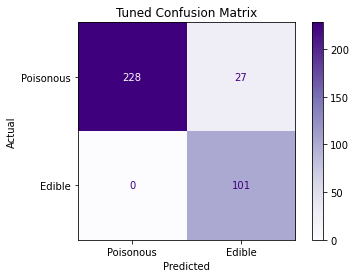

<Figure size 432x288 with 0 Axes>

In [76]:
ls = ['Poisonous','Edible']
disp = ConfusionMatrixDisplay(confusion_matrix=tuned_con_mat, display_labels=ls)
disp.plot(cmap = 'Purples')
plt.grid(False)
plt.title("Tuned Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig("Tuned Confusion Matrix.png", bbox_inches = "tight");

# Additional Layers Confusion Matrix

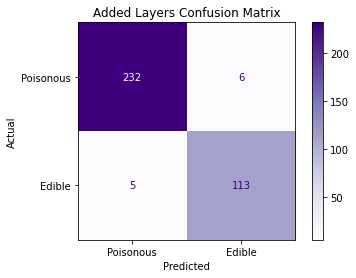

<Figure size 432x288 with 0 Axes>

In [86]:
val_predicts_2 = Sequential_NN.predict(test_ds) 
y_pred_2 = 1*(val_predicts_2 >= 0.5) 
true_classes_2 = tf.concat([y for x, y in test_ds], axis=0)
add_layers_con_mat = tf.math.confusion_matrix(labels = true_classes_2, predictions=y_pred_2).numpy()

add_layers_con_mat = np.flip(add_layers_con_mat,1)
add_layers_con_mat

ls = ['Poisonous','Edible']
disp = ConfusionMatrixDisplay(confusion_matrix=add_layers_con_mat, display_labels=ls)
disp.plot(cmap = 'Purples')
plt.grid(False)
plt.title("Added Layers Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig("Additional Layers Confusion Matrix.png", bbox_inches = "tight");

# Baseline Confusion Matrix

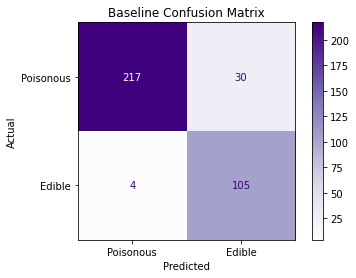

<Figure size 432x288 with 0 Axes>

In [79]:
base_pred = Baseline_NN.predict(test_ds) 
y_base_pred = 1*(base_pred >= 0.5) 
true_classes_base = tf.concat([y for x, y in test_ds], axis=0)
base_con_mat = tf.math.confusion_matrix(labels = true_classes_base, predictions=y_base_pred).numpy()

base_con_mat = np.flip(base_con_mat,1)
base_con_mat

ls = ['Poisonous','Edible']
disp = ConfusionMatrixDisplay(confusion_matrix=base_con_mat, display_labels=ls)
disp.plot(cmap = 'Purples')
plt.grid(False)
plt.title("Baseline Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig("Baseline Confusion Matrix.png", bbox_inches = "tight");

In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
148/161

# Baseline Accuracy and Loss

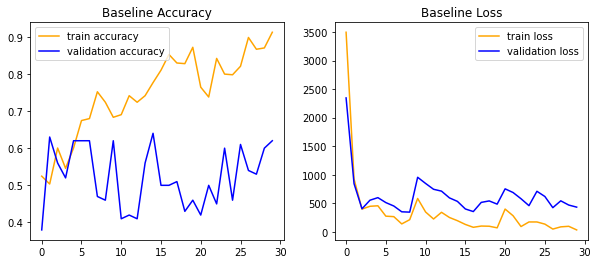

In [80]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Baseline Accuracy")
plt.plot(baseline_history.history['accuracy'], label='train accuracy', color='orange')
plt.plot(baseline_history.history['val_accuracy'], label='validation accuracy', color='blue')
plt.legend()

plt.subplot(1,2,2)
plt.title("Baseline Loss")
plt.plot(baseline_history.history['loss'], label='train loss', color='orange')
plt.plot(baseline_history.history['val_loss'], label='validation loss', color='blue')
plt.legend()

plt.savefig("accuracy_and_loss_baseline.png", bbox_inches = "tight");

plt.show()

# Baseline Precision

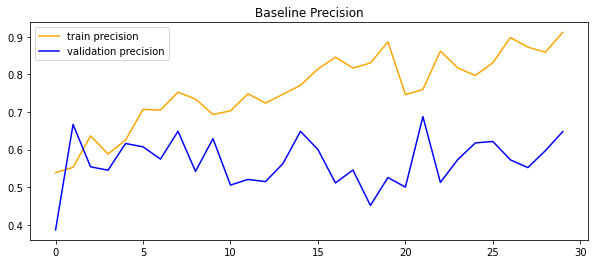

In [81]:
plt.figure(figsize=(10,4))

plt.plot(baseline_history.history['precision'], label='train precision', color='orange')
plt.plot(baseline_history.history['val_precision'], label='validation precision', color='blue')
plt.legend()
plt.title("Baseline Precision")
plt.savefig("precision_baseline.png", bbox_inches = "tight");

plt.show()

# Additional Layers Accuracy and Loss

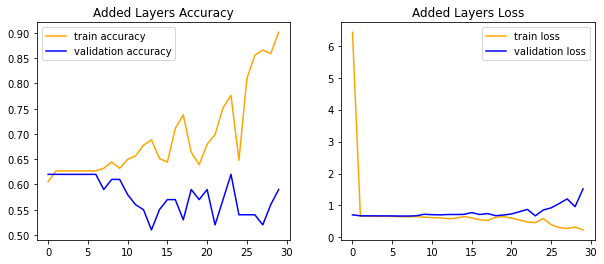

In [82]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Added Layers Accuracy")
plt.plot(history.history['accuracy'], label='train accuracy', color='orange')
plt.plot(history.history['val_accuracy'], label='validation accuracy', color='blue')
plt.legend()

plt.subplot(1,2,2)
plt.title("Added Layers Loss")
plt.plot(history.history['loss'], label='train loss', color='orange')
plt.plot(history.history['val_loss'], label='validation loss', color='blue')
plt.legend()

plt.savefig("accuracy_and_loss_add_layers.png", bbox_inches = "tight");

plt.show()

# Additional Layers Precision

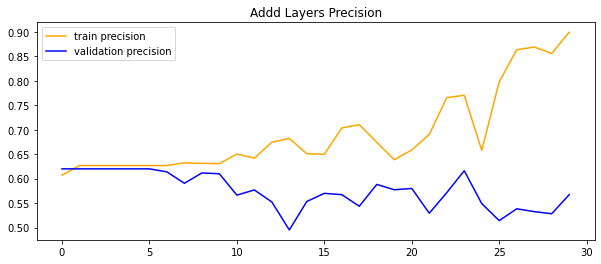

In [83]:
plt.figure(figsize=(10,4))

plt.plot(history.history['precision'], label='train precision', color='orange')
plt.plot(history.history['val_precision'], label='validation precision', color='blue')
plt.legend()
plt.title("Addd Layers Precision")
plt.savefig("precision_add_layers.png", bbox_inches = "tight");

plt.show()

# Mobile Net Accuracy and Loss

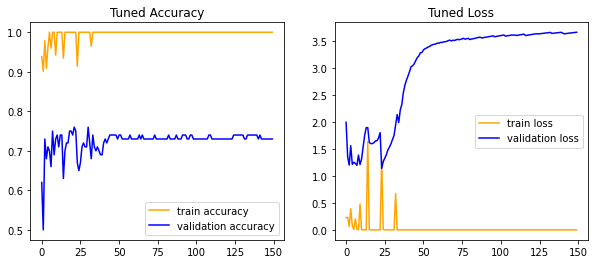

In [87]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(mobile_net_hist.history['accuracy'], label='train accuracy', color='orange')
plt.plot(mobile_net_hist.history['val_accuracy'], label='validation accuracy', color='blue')
plt.title("Tuned Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(mobile_net_hist.history['loss'], label='train loss', color='orange')
plt.plot(mobile_net_hist.history['val_loss'], label='validation loss', color='blue')
plt.legend()
plt.title("Tuned Loss")
plt.savefig("accuracy_and_loss_tuned.png", bbox_inches = "tight");

plt.show()

# Mobile Net Precision

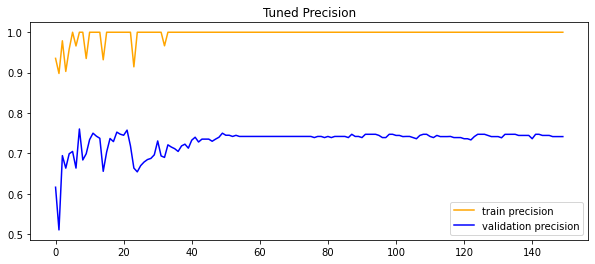

In [85]:
plt.figure(figsize=(10,4))

plt.plot(mobile_net_hist.history['precision'], label='train precision', color='orange')
plt.plot(mobile_net_hist.history['val_precision'], label='validation precision', color='blue')
plt.legend()
plt.title("Tuned Precision")
plt.savefig("precision_baseline.png", bbox_inches = "tight");
plt.show()